## B cells versus T cells
The data used in this notebook is lymphocyte data for one patient's B cells and T cells. We use this data to show the proteome variation between the cell types. Here, we note presence/absense changes and quantify fold changes using a T test.


First, we import our loader module. This brings the functions defined there (in our repository at ~/load_data.py) into scope so we can use them in this script. Then we can load our data and store it as <code>data</code>.

Calling <code>head</code> shows the first several lines of the dataframe, which provides an idea of the type of data present and the structure of the dataframe.

In [1]:
import load_data
#data_raw = load_data.load_FragPipe()
data_raw=load_data.load_max_quant()

data_raw

,Intensity B_C10,Intensity B_C11,Intensity B_C12,Intensity B_C13,Intensity B_C9,Intensity T_D10,Intensity T_D11,Intensity T_D12,Intensity T_D13,Intensity T_D9
Protein IDs,,,,,,,,,,
P0DPI2;A0A0B4J2D5,265300,248290,1878900,289210,0,0,0,0,0,654710
A0AVT1,0,0,440250,0,0,0,0,0,0,0
A6NGU5;P19440,0,0,0,0,0,0,0,0,2590400,0
A6NHQ2,126410,0,0,89903,0,263160,0,0,110120,0
A6NI72;P14598;A8MVU1,1146300,1354400,2254700,2912100,1045700,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
Q9Y5J7,313760,0,0,0,0,0,259020,0,0,237540
Q9Y5S9,766910,415980,458400,452850,862000,343680,495150,551340,766580,0
Q9Y5X3,291730,748590,1022100,133040,510570,0,0,0,0,0


These are some methods that assist with the data analysis, such as checking if a value was measured or not and if the protein was measured in each type.

In [2]:
import data_utils

Before any analysis, we log normalize and median normalize across runs.

In [3]:
data_log2_normalized = data_utils.normalize(data_raw)

Our next steps will require separating the runs by cell type, to compare B cells to T cells. As you see above, the pattern for naming the columns is "Intensity ", B or T indicating cell type, and the replicate number. Here we define the list of cell types that the functions should look for based on the naming pattern.

In [4]:
cell_types=[' B_', ' T_']

Here we record which proteins are only identified in one cell type. We'll set these aside for now, in the <code>data_in_one_type</code> dataframe. Note that <code>min_reps</code> is the minimum number of replicates required to list a protein as present in one type. This can be changed, i.e., <code>min_reps=5</code> to determine the proteins identified in all 5 replicates of a single type; do not set it to a number greater than the replicates run or no proteins will be returned.

In [5]:
present_only_in = data_log2_normalized.apply(data_utils.check_presence_absence, axis=1, 
                                             min_reps=3, cell_types=cell_types).dropna()
print("Proteins identified only in:")
print(present_only_in.value_counts())
data_in_one_type =data_log2_normalized.loc[present_only_in.index]
data_in_one_type['Type'] = present_only_in

Proteins identified only in:
 T_    49
 B_    38
dtype: int64


Next, we select the proteins that are measured in at least three samples from each group, allowing the calculations to proceed without imputed zero-handling.

In [6]:
indecies = data_log2_normalized.apply(data_utils.check_three_of_each_type, axis=1, cell_types=cell_types)
data = data_log2_normalized[indecies]

In [7]:
print ("Total groups identified:")
print(data_raw.shape[0])

print ("Proteins identified in at least 3 of each cell type:\t")
print (data.shape[0])

Total groups identified:
1211
Proteins identified in at least 3 of each cell type:	
589


Now we calulate p values using a ttest. 

In [8]:
#Call ttest function
tstats = data.apply(data_utils.ttest_wrapper, axis=1, cell_types=cell_types)

D:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


Here we calculate fold change.

In [9]:
tstats['log2(B)-log2(T)'] = data.apply(data_utils.get_fold_changes, axis=1, cell_types=cell_types)

Fold change and p values allow us to create a volcano plot.

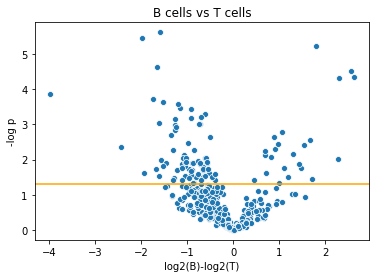

In [10]:
#graph volcano
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import log10
tstats['-log p'] = -log10(tstats['pvalue'])

figure = sns.scatterplot(x='log2(B)-log2(T)',y='-log p',data=tstats)
figure.set_title("B cells vs T cells")
#plt.axvline(1, color ='orange')
#plt.axvline(-1, color ='orange')
plt.axhline(-log10(.05), color ='orange')
plt.show()

Next we will identify the altered proteins.

In [11]:
altered = tstats.apply(data_utils.is_altered, axis=1, change_factor=False).dropna()

These are significantly altered (p<0.01) without restricting by the magnitude of change:

In [12]:
altered.value_counts()

T cells    30
B cells    15
dtype: int64

In [13]:
print("Here are counts for other p and change cutoffs:")
print("P<0.05, >150% of the other type")
print(tstats.apply(data_utils.is_altered, axis=1, pvalue=.05,change_factor=1.5).value_counts()) #50% increase from either
print("\nP<0.05, >200% of the other type")
print(tstats.apply(data_utils.is_altered, axis=1, pvalue=.05,change_factor=2).value_counts()) #Double
print("\nP<0.05, >500% of the other type")
print(tstats.apply(data_utils.is_altered, axis=1, pvalue=.05,change_factor=5).value_counts()) #5 times larger

print("\nP<0.01, >150% of the other type")
print(tstats.apply(data_utils.is_altered, axis=1, pvalue=.01,change_factor=1.5).value_counts()) #50% increase from either
print("\nP<0.01, >200% of the other type")
print(tstats.apply(data_utils.is_altered, axis=1, pvalue=.01,change_factor=2).value_counts()) #Double
print("\nP<0.01, >500% of the other type")
print(tstats.apply(data_utils.is_altered, axis=1, pvalue=.01,change_factor=5).value_counts()) #5 times larger

Here are counts for other p and change cutoffs:
P<0.05, >150% of the other type
T cells    65
B cells    22
dtype: int64

P<0.05, >200% of the other type
T cells    35
B cells    14
dtype: int64

P<0.05, >500% of the other type
B cells    2
T cells    2
dtype: int64

P<0.01, >150% of the other type
T cells    28
B cells    15
dtype: int64

P<0.01, >200% of the other type
T cells    19
B cells     9
dtype: int64

P<0.01, >500% of the other type
B cells    2
T cells    2
dtype: int64


### Differentially expressed proteins

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.]),
 <a list of 8 Text major ticklabel objects>)

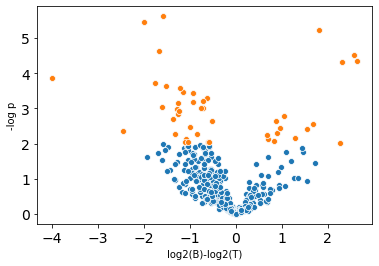

In [14]:
figure = sns.scatterplot(x='log2(B)-log2(T)',y='-log p',data=tstats)
figure2 = sns.scatterplot(x='log2(B)-log2(T)',y='-log p',data=tstats.loc[altered.index])
plt.rc('axes',labelsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.title("B cells vs T cells", fontsize=20)

#plt.savefig("data/BvsT.png", dpi=300)

This shows the differentially expressed proteins. Recall that this dataset is restricted to those expressed in at least three of each cell type.

The next step is to identify those proteins by name. Here we get the protein names from the fasta file, which remain the same regardless of which software the data was quantified using.

In [15]:
protein_names = load_data.load_fasta()

In [16]:
import pandas as pd
protein_names_by_group={}
for ID in data_raw.index:
    if ';' in ID:
        ids = ID.split(';')
        names=''
        for i in ids:
            if i in protein_names.index:
                names=names + protein_names[i] + ';'
        names = names[:-1]
        protein_names_by_group[ID] = names
    else:
        if ID in protein_names.index:
            protein_names_by_group[ID]=protein_names[ID]
protein_names_by_group = pd.Series(list(protein_names_by_group.values()), index=protein_names_by_group.keys())

Here we add the names to the <code>tstats</code> dataframe, which contains the fold changes for each protein. Then we can list the proteins that are altered. Optionally, use <code> head()</code> to display the first few or <code>to_csv</code> to write out to a file. We now split up the proteins heightened in B cells from those heightened in T cells.

In [17]:
tstats['Name']=protein_names_by_group
tstats['GeneID'] = tstats.Name.apply(lambda n: str(n).split('_HUMAN')[0])

altered_proteins = tstats.loc[altered.index].sort_values('log2(B)-log2(T)',
                        ascending=False)[['pvalue','log2(B)-log2(T)','Name','GeneID']]
higher_in_B_cells = altered_proteins.loc[altered_proteins['log2(B)-log2(T)'] >0]
higher_in_T_cells = altered_proteins.loc[altered_proteins['log2(B)-log2(T)'] <0]

#To write out to a file, use:
#altered_proteins.to_csv('data/filename.tsv', sep='\t')

Next we do the same for those only identified in one cell type.

In [18]:
data_in_one_type['Name'] = protein_names_by_group
data_in_one_type['GeneID']=data_in_one_type.Name.apply(lambda n: str(n).split('_HUMAN')[0])

B_cell_only_geneset = data_in_one_type[(data_in_one_type.Type==' B_')]
T_cell_only_geneset= data_in_one_type[(data_in_one_type.Type==' T_')]

### Proteins Higher in B Cells:

In [19]:
higher_in_B_cells

,pvalue,log2(B)-log2(T),Name,GeneID
Protein IDs,,,,
P09960,0.000045,2.626130,LKHA4_HUMAN Leukotriene A-4 hydrolase,LKHA4
Q96KP4,0.000029,2.567266,CNDP2_HUMAN Cytosolic non-specific dipeptidase,CNDP2
P29350,0.000048,2.302902,PTN6_HUMAN Tyrosine-protein phosphatase non-re...,PTN6
Q16666;Q6K0P9,0.009769,2.267724,IF16_HUMAN Gamma-interferon-inducible protein ...,IF16
P09874,0.000006,1.805240,PARP1_HUMAN Poly [ADP-ribose] polymerase 1,PARP1
P53396,0.002844,1.671055,ACLY_HUMAN ATP-citrate synthase,ACLY
P58546,0.003921,1.543587,MTPN_HUMAN Myotrophin,MTPN
P50395,0.006946,1.291659,GDIB_HUMAN Rab GDP dissociation inhibitor beta,GDIB
P15311,0.001631,1.049916,EZRI_HUMAN Ezrin,EZRI


### Proteins Only in B Cells:

In [20]:
B_cell_only_geneset[['Name', 'GeneID']]

,Name,GeneID
Protein IDs,,
A6NI72;P14598;A8MVU1,NCF1B_HUMAN Putative neutrophil cytosol factor...,NCF1B
O00151,PDLI1_HUMAN PDZ and LIM domain protein 1,PDLI1
O15400,TX7_HUMAN Syntaxin-7,TX7
O60262,GBG7_HUMAN Guanine nucleotide-binding protein ...,GBG7
O60493,NX3_HUMAN Sorting nexin-3,NX3
P00352,AL1A1_HUMAN Retinal dehydrogenase 1,AL1A1
P01871;P0DOX6,IGHM_HUMAN Immunoglobulin heavy constant mu,IGHM
P01903;P01906;P52735,DRA_HUMAN HLA class II histocompatibility anti...,DRA
P01911,2B1F_HUMAN HLA class II histocompatibility ant...,2B1F


### Proteins higher or only in B cells by GeneID
<code>B_cell_set</code> is defined here as both the above lists of names, those higher or only in B cells.

In [21]:
B_cell_set = list(higher_in_B_cells.GeneID)+list(B_cell_only_geneset.GeneID)

### Proteins Higher in T Cells:

In [22]:
higher_in_T_cells.sort_values('log2(B)-log2(T)',ascending=True)

,pvalue,log2(B)-log2(T),Name,GeneID
Protein IDs,,,,
P26447,0.000140,-3.987732,10A4_HUMAN Protein S100-A4,10A4
Q09666,0.004426,-2.451097,AHNK_HUMAN Neuroblast differentiation-associat...,AHNK
Q9UI08,0.000003,-1.994234,EVL_HUMAN Ena/VASP-like protein,EVL
P07195;Q6ZMR3;P07864,0.000193,-1.752858,LDHB_HUMAN L-lactate dehydrogenase B chain ;LD...,LDHB
P08670;P41219;P17661;Q16352;P07197;P07196,0.000023,-1.658728,VIME_HUMAN Vimentin ;PERI_HUMAN Peripherin ;DE...,VIME
O75347,0.000920,-1.605149,TBCA_HUMAN Tubulin-specific chaperone A,TBCA
O75083,0.000002,-1.590065,WDR1_HUMAN WD repeat-containing protein 1,WDR1
P21333;Q14315,0.000232,-1.520571,FLNA_HUMAN Filamin-A ;FLNC_HUMAN Filamin-C,FLNA
P60660;P14649,0.002014,-1.357658,MYL6_HUMAN Myosin light polypeptide 6 ;MYL6B_H...,MYL6


### Proteins Only in T Cells:

In [23]:
T_cell_only_geneset[['Name', 'GeneID']]

,Name,GeneID
Protein IDs,,
P47813;O14602,IF1AX_HUMAN Eukaryotic translation initiation ...,IF1AX
O15117,FYB1_HUMAN FYN-binding protein 1,FYB1
O60610,DIAP1_HUMAN Protein diaphanous homolog 1,DIAP1
O94804;Q9H2G2,TK10_HUMAN Serine/threonine-protein kinase 10 ...,TK10
P02545,LMNA_HUMAN Prelamin-A/C,LMNA
P04083,ANXA1_HUMAN Annexin A1,ANXA1
P05107,ITB2_HUMAN Integrin beta-2,ITB2
P06127,CD5_HUMAN T-cell surface glycoprotein CD5,CD5
P06239,LCK_HUMAN Tyrosine-protein kinase Lck,LCK


### Proteins higher or only in T cells by GeneID
<code>T_cell_set</code> is defined here as both the above lists of names, those higher or only in T cells.

In [24]:
T_cell_set = list(higher_in_T_cells.GeneID)+list(T_cell_only_geneset.GeneID)